In [1]:
import numpy as np
import pandas as pd
SEED = 20193575

In [2]:
# Loads the data from csv
data_df = pd.read_csv("data/existing-customers.csv", sep=";", index_col=0)
potential_df = pd.read_csv("data/potential-customers.csv", sep=";", index_col=0)
# Drop all rows with missing values (Look at report for more info)
data_df.dropna(inplace=True)

# Drop columns that could be somewhat biased - sex could be inferred from relationship so it must be dropped too
data_df.drop(["age", "race", "sex", "native-country", "relationship"], axis=1, inplace=True)
potential_df.drop(["age", "race", "sex", "native-country", "relationship"], axis=1, inplace=True)

# Make all values numerical (split them into categories and number these categories)
data_df = pd.get_dummies(data_df, drop_first=True)
potential_df = pd.get_dummies(potential_df, drop_first=True)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_df.drop(data_df.columns[-1], axis=1), data_df.iloc[:, -1], test_size=0.10, random_state=SEED)

In [4]:
X_train.insert(0, "label", y_train)
highearners = X_train[X_train["label"] == True]
lowearners = X_train[X_train["label"] == False]
x = lowearners.sample(frac=1/3, random_state=SEED)
y = highearners.sample(frac=1, random_state=SEED, replace=True)
X_train = pd.concat([x, y], axis=0)
y_train = X_train["label"]
X_train.drop("label", axis=1, inplace=True)
y_train.value_counts()

label
False    6791
True     6772
Name: count, dtype: int64

In [5]:
# Import classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Set up classifiers
classifiers = {
    "KNN": KNeighborsClassifier(),
    "Decision trees": DecisionTreeClassifier(),
    "Complement Naïve bayes": ComplementNB(),
    "Naïve bayes": CategoricalNB(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(solver="newton-cholesky")
}
classifier_meta = {key: dict() for key in classifiers.keys()}

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sn


def calculate_profit(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    return (cm[0,0] * (980 * 0.1 - 10)) - (cm[1,0] * (310 * 0.05 + 10))


def backwards_feature_selection(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame, classifier, name):
    classifier.fit(X_train, y_train)
    best_profit = calculate_profit(classifier.predict(X_test[X_train.columns]), y_test)
    best_features = X_train.columns
    i = 0
    while True:
        has_improved = False
        Xtr = X_train[best_features]
        Xte = X_test[best_features]
        for col in Xtr.columns:
            _xtr = Xtr.drop(col, axis=1)
            _xte = Xte.drop(col, axis=1)
            classifier.fit(_xtr, y_train)
            profit = calculate_profit(classifier.predict(_xte), y_test)
            if profit > best_profit:
                best_features = _xtr.columns
                best_profit = profit
                has_improved = True
        if not has_improved:
            break
        i += 1
    print(f"Removed {i} columns to reach optimal profit")
    print(f"Best profit for classifier after feature selection €{best_profit}")
    return best_features


def find_optimal_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    # Compute the optimal threshold for maximum profit
    opt_idx = -1
    max_profit = float('-inf')
    thresholds = np.append(thresholds, 0.5)
    cm = confusion_matrix(y_true, (y_probs > 0.5).astype(bool), labels=[True, False])
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]
    fpr = np.append(fpr, fp/(fp+tn))
    tpr = np.append(tpr, tp/(tp+fn))
    for idx, threshold in enumerate(thresholds):
        y_preds = (y_probs > threshold).astype(bool)
        cm = confusion_matrix(y_true, y_preds, labels=[True, False])
        profit = (cm[0,0] * (980 * 0.1 - 10)) - (cm[1,0] * (310 * 0.05 + 10))
        if profit > max_profit:
            max_profit = profit
            opt_idx = idx

    # Return the corresponding threshold true positive and false positive rates
    return fpr[opt_idx], tpr[opt_idx], thresholds[opt_idx]

def training_prediction(X, y_true, name, classifier, verbose=True):
    y_probs = classifier.predict_proba(X)[:, 1]

    y_preds = classifier.predict(X)
    cm = confusion_matrix(y_true, y_preds, labels=[True, False])
    initial_profit = (cm[0,0] * (980 * 0.1 - 10)) - (cm[1,0] * (310 * 0.05 + 10))
    print(f"Initial Profit: {initial_profit:.2f}")

    opt_fpr, opt_tpr, opt_thres = find_optimal_threshold(y_true, y_probs)

    # Use the optimal threshold to make predictions
    y_preds = y_probs >= opt_thres
    cm = confusion_matrix(y_true, y_preds, labels=[True, False])
    profit = (cm[0,0] * (980 * 0.1 - 10)) - (cm[1,0] * (310 * 0.05 + 10))

    if verbose:
        # Plot PR-cruve
        p, r, _ = precision_recall_curve(y_true, y_probs)
        plt.figure(figsize = (12, 5))
        plt.subplot(1, 3, 1)
        plt.plot(r, p)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        
        # Plot ROC curve and confusion matrix
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        plt.subplot(1, 3, 2)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')

        plt.subplot(1, 3, 3)
        sn.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=[True, False], yticklabels=[True, False])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix for {name} Classifier')
        plt.tight_layout()

        # Print results and estimated profit
        print(classification_report(y_true, y_preds))
    print(f"Optimal Threshold: {opt_thres} with a FPR: {opt_fpr*100:.2f}% and TPR: {opt_tpr*100:.2f}%")
    print(f"Estimated Profit: {profit:.2f}")
    return opt_fpr, precision_score(y_true, y_preds), opt_thres, profit

MAX PROFIT TO GAIN IN SUBSET €64768
_.-====== Statistics and optimization for KNN classifier ======-._
Removed 7 columns to reach optimal profit
Best profit for classifier after feature selection €43080.5
-:====== KNN classifier optimization done ======:-
Initial Profit: 43080.50
              precision    recall  f1-score   support

       False       0.96      0.67      0.79      2281
        True       0.48      0.92      0.63       736

    accuracy                           0.73      3017
   macro avg       0.72      0.80      0.71      3017
weighted avg       0.85      0.73      0.75      3017

Optimal Threshold: 0.4 with a FPR: 32.70% and TPR: 92.39%
Estimated Profit: 40817.00

_.-====== Statistics and optimization for Decision trees classifier ======-._
Removed 13 columns to reach optimal profit
Best profit for classifier after feature selection €43567.5
-:====== Decision trees classifier optimization done ======:-
Initial Profit: 43567.50
              precision    recall  f1-

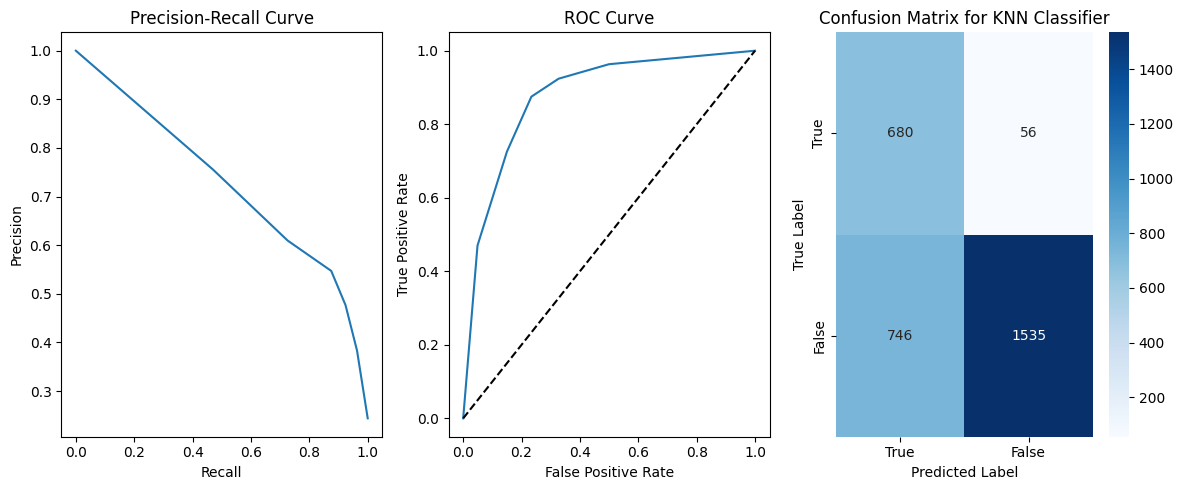

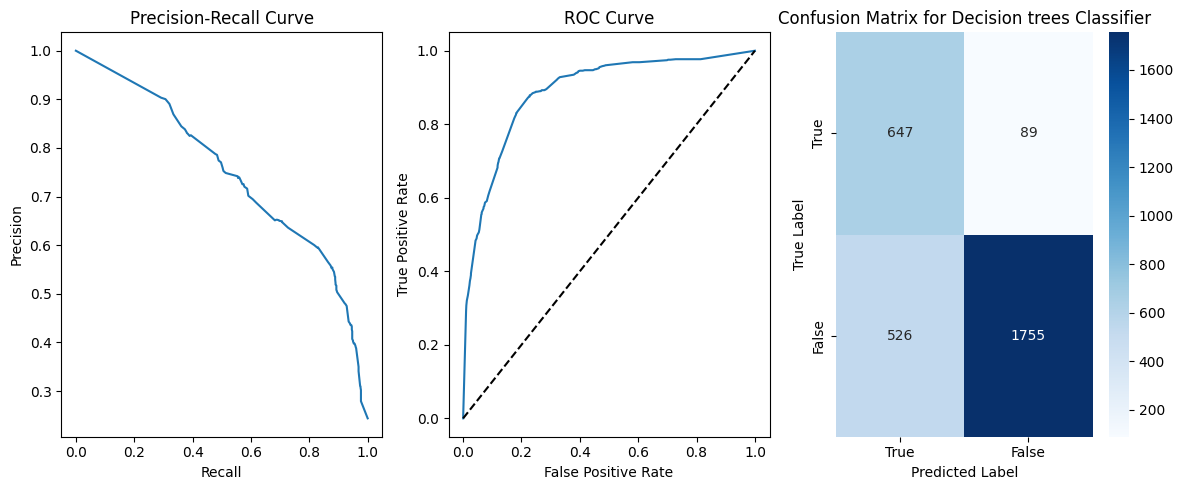

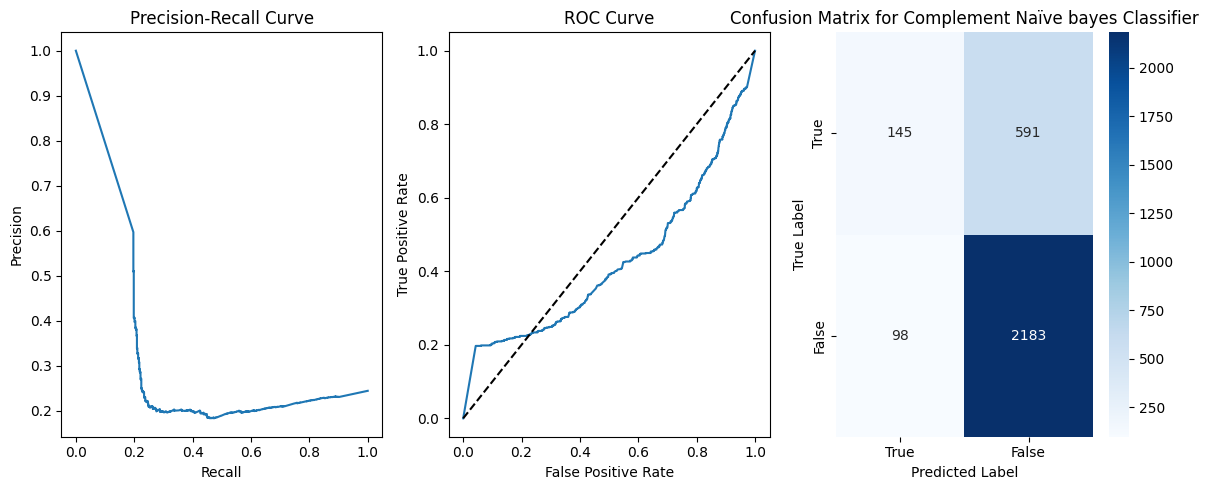

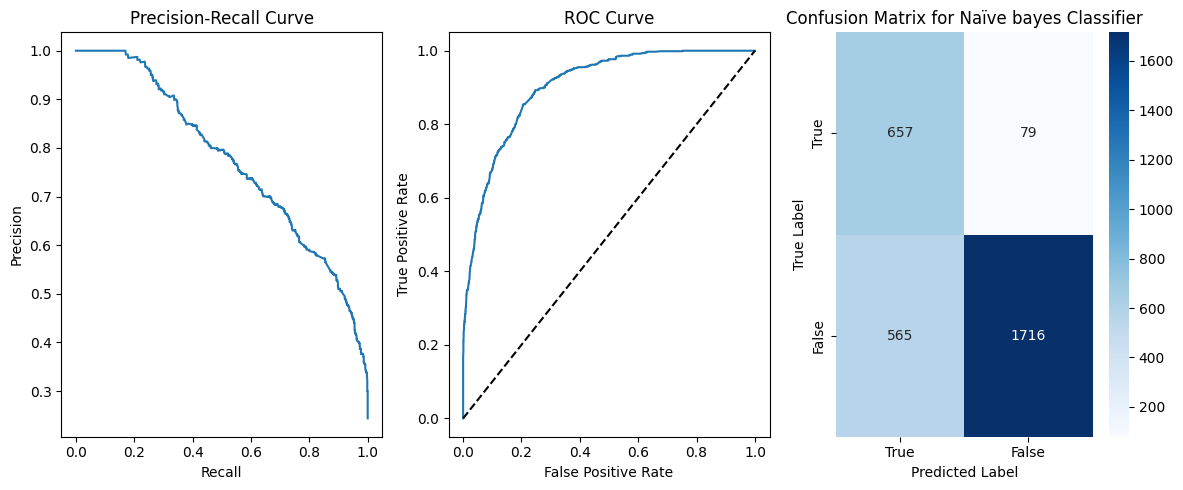

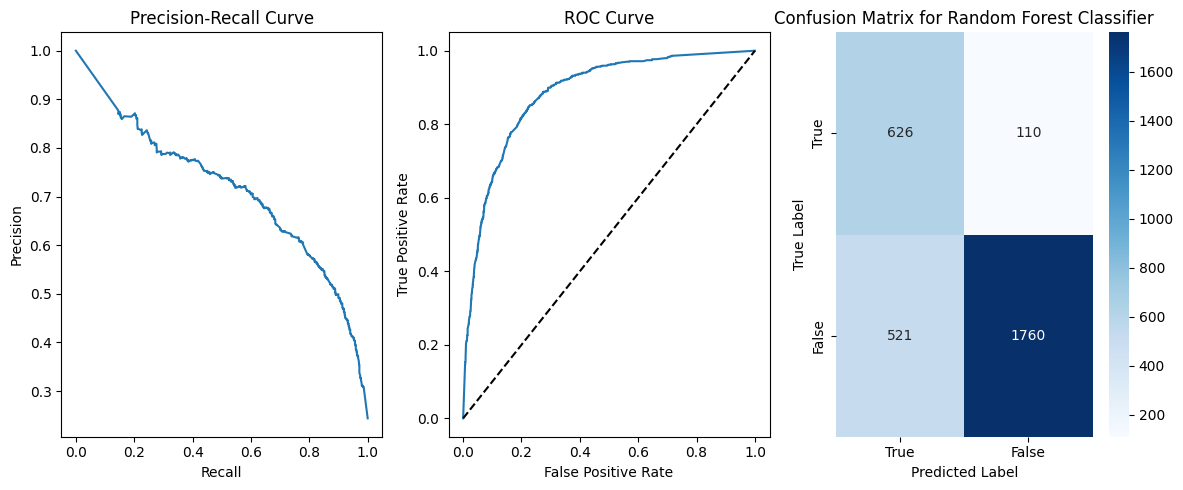

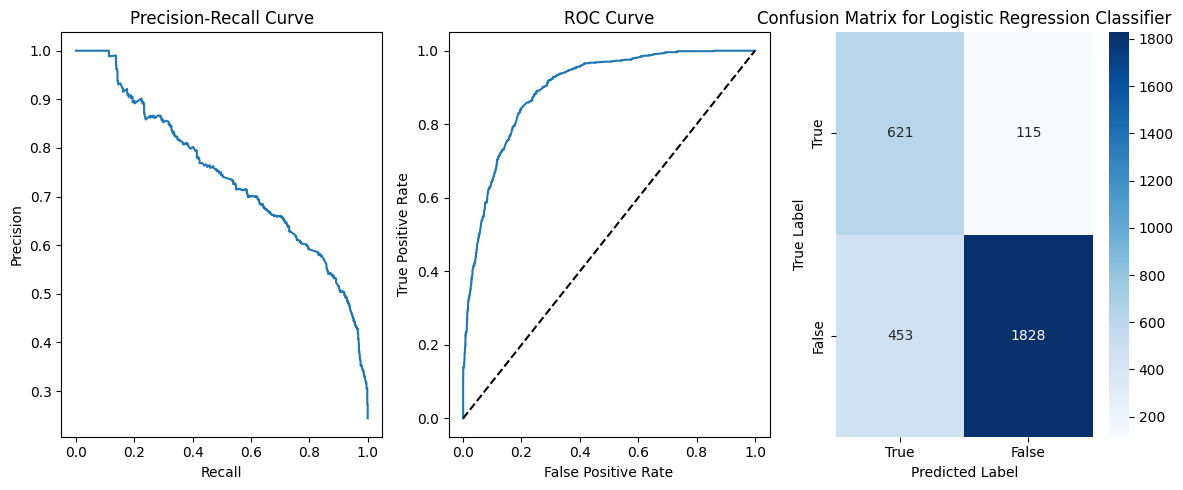

In [7]:
max_possible_profit = y_test.sum() * (980 * 0.1 - 10)
print(f"MAX PROFIT TO GAIN IN SUBSET €{max_possible_profit:.0f}")
for name, classifier in classifiers.items():
    print(f"_.-====== Statistics and optimization for {name} classifier ======-._")
    cols = backwards_feature_selection(X_train, X_test, y_train, y_test, classifier, name)
    print(f"-:====== {name} classifier optimization done ======:-")
    classifier.fit(X_train[cols], y_train)
    meta = training_prediction(X_test[cols], y_test, name, classifier, verbose=True)
    classifier_meta[name] = {
        "fpr": meta[0],
        "precision": meta[1],
        "opt_thres": meta[2],
        "cols": cols
    }
    print()

In [8]:
for name, classifier in classifiers.items():
    cols = classifier_meta[name]["cols"]
    # Re-fit classifier on the best feature set
    classifier.fit(X_train[cols], y_train)
    y_pred = (classifier.predict_proba(potential_df[cols])[:, 1] >= classifier_meta[name]["opt_thres"]).astype(bool)
    y_pred = pd.DataFrame(y_pred, columns=["class"], index=potential_df.index)
    pot_customers = pd.concat([potential_df, y_pred], axis=1)

    positive = np.floor(classifier_meta[name]["precision"] * y_pred.sum())
    negative = y_pred.sum() - positive
    profit = (positive * (980 * 0.1 - 10)) - (negative * (310 * 0.05 + 10))

    print(f"{name}: Estimated profit: €{float(profit.iloc[0]):.2f}")

    # Produce text file with row ids
    row_ids = pot_customers[pot_customers["class"] == True].index.tolist()
    with open('output/selected-customers_{}.txt'.format(name), "w") as file:
        file.write(",".join(row_ids))

KNN: Estimated profit: €213265.00
Decision trees: Estimated profit: €232197.50
Complement Naïve bayes: Estimated profit: €55752.50
Naïve bayes: Estimated profit: €231282.00
Random Forest: Estimated profit: €223493.00
Logistic Regression: Estimated profit: €231651.50
